In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
data = pd.read_stata("workdir/PFT_CORR.dta")

# data.fillna(0)

data[['AGE', 'SM0101', 'SM0102',
       'SM0401', 'SM040101', 'SM0402', 'SM040201', 'SM0403', 'SM0404',
       'SM040401', 'SM0405', 'SM040501']]=data[['AGE', 'SM0101', 'SM0102',
       'SM0401', 'SM040101', 'SM0402', 'SM040201', 'SM0403', 'SM0404',
       'SM040401', 'SM0405', 'SM040501']].apply(pd.to_numeric,errors='coerce')

# data
# data = data.drop(data.loc[:,'SM0101':'SEQ1'], axis=1)
# data = data.drop(data.loc[:,'SM_DATE01':'SEQ1'], axis=1)
data = data.drop(data.loc[:,'SM_DATE01':'SEQ1'], axis=1)
data = data.drop('PKGTYP',axis=1)
data.rename(columns={'SEX':'GENDER', 'YYYY':'YEAR'},inplace=True)
data = data.sort_values(['SM_DATE','CDW_ID'])

In [3]:
data = data.drop(data.loc[data['GENDER']==""].index) # nan이 아니어서 이렇게 적용
data = data.drop(data.loc[data['AGE']==""].index) # nan이 아니어서 이렇게 적용
data.dropna(subset=['SM0101'],inplace=True)
data.dropna(subset=['SM0102'],inplace=True)

# data

# 최정근식 calculated value

In [4]:
# 최정근식 기준값 반영
data.loc[(data['GENDER'] =='F'),'pred_fvc'] = round((-3.0006 - (0.0001273 *data['AGE']*data['AGE'])) + (0.03951*data['SM0101']) + (0.006892*data['SM0102']),2)
data.loc[(data['GENDER'] =='M'),'pred_fvc'] = round((-4.8434 - (0.00008633 *data['AGE']*data['AGE'])) + (0.05292*data['SM0101']) + (0.01095*data['SM0102']),2)

data.loc[(data['GENDER'] =='F'),'pred_FEV1']                       = round((-2.4114 - (0.0001920 *data['AGE']*data['AGE'])) + (0.03558*data['SM0101']),2)
data.loc[(data['GENDER'] =='M') & (data['AGE'] <= 99),'pred_FEV1'] = round((-3.4132 - (0.0002484 *data['AGE']*data['AGE'])) + (0.04578*data['SM0101']),2)

data.loc[(data['GENDER'] =='F') & (18 <= data['AGE']) & (data['AGE'] <= 99),'pred_FEV1/FVC'] = round(97.8567 - (0.2800*data['AGE']) - (0.01564*data['SM0101']))
data.loc[(data['GENDER'] =='M') & (18 <= data['AGE']) & (data['AGE'] <= 99),'pred_FEV1/FVC'] = round(119.9004 - (0.3902*data['AGE']) - (0.1268*data['SM0101']))

In [5]:
# 보정된 예측값으로 재계산
data['cal_fvc%'] = round(data['SM0401']/data['pred_fvc'] * 100)
data['cal_FEV1%'] = round(data['SM0402']/data['pred_FEV1'] * 100)
# data['cal_FEV1%'] = pd.to_numeric(round(data['SM0402']/data['pred_FEV1'] * 100),downcast='integer')
# data.dtypes

In [6]:
data.loc[(data['cal_fvc%'] != data['SM040101']),'FVC%_DIFF'] = 'Y'
data.loc[(data['cal_fvc%'] == data['SM040101']),'FVC%_DIFF'] = 'N'
# data

# cal_fvc% value distribution with gender

C:\Users\DM500T8Z-AD3A\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\DM500T8Z-AD3A\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


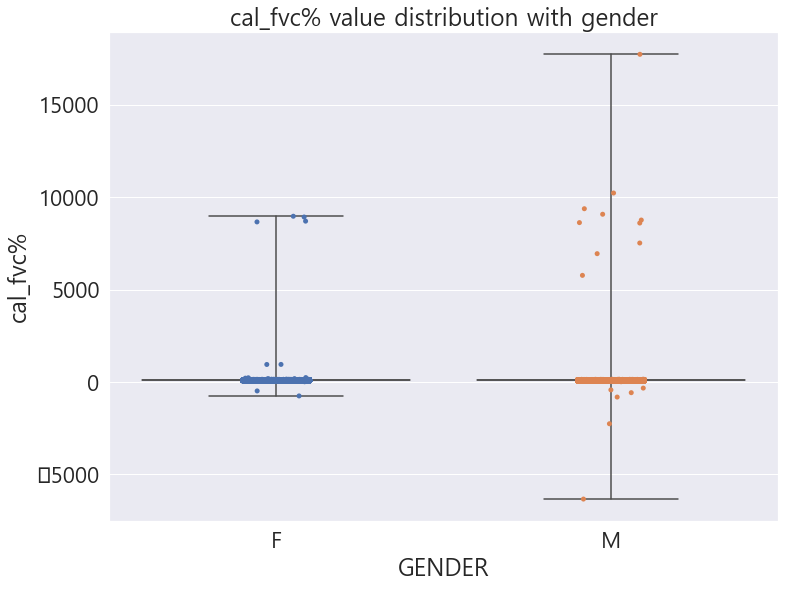

In [7]:
sns.set(font_scale = 2,font='Malgun Gothic',style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
# plt.rcParams['font.family'] = 'SGL' #삼성고딕체
plt.title("cal_fvc% value distribution with gender")
sns.boxplot(x="GENDER", y="cal_fvc%",data=data, whis=np.inf)
sns.stripplot(x="GENDER", y="cal_fvc%",data=data, jitter=True)#, color="0.4")

plt.show()

# Outlier delete

In [8]:
# Outlier 제거
data.loc[(data['cal_fvc%'] < 0) | (data['cal_fvc%'] > 200),'outlier'] = 'Y'
data2 = data.drop(data.loc[data['outlier']=='Y'].index)

# data2

# cal_fvc% value distribution(outlier remove)

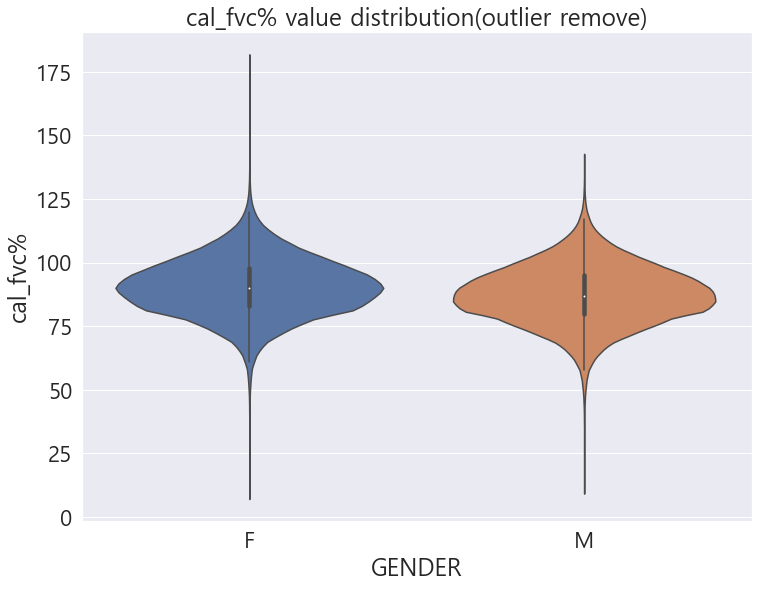

In [9]:
sns.set(font_scale = 2,font='Malgun Gothic',style='darkgrid')
plt.rcParams['figure.figsize'] = (12, 9)
# plt.rcParams['font.family'] = 'SGL' #삼성고딕체
plt.title("cal_fvc% value distribution(outlier remove)")
# sns.boxplot(x="SEX", y="cal_fvc%",data=data2, whis=np.inf) # whis=np.inf
# sns.stripplot(x="SEX", y="cal_fvc%",data=data2, jitter=True)#, color="0.4")
sns.violinplot(x="GENDER", y="cal_fvc%",data=data2)

plt.show()

# FVC% differences distribution

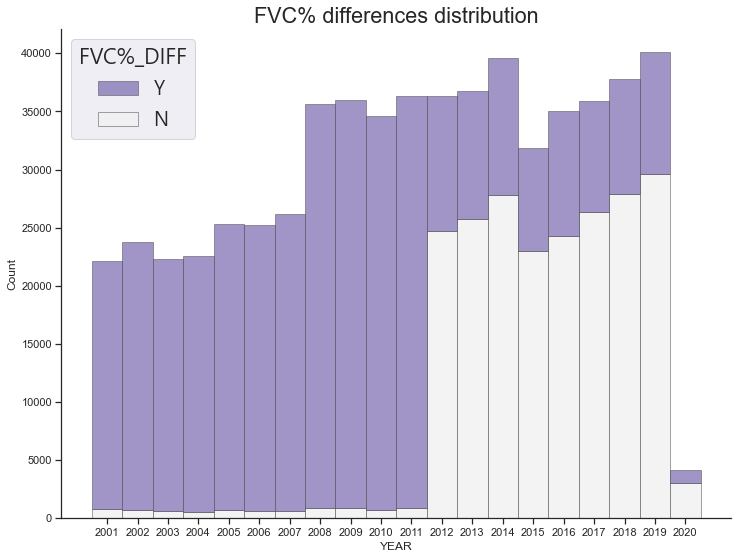

In [10]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(12, 9))
sns.despine(f)

sns.set(font_scale = 1.8,font='Malgun Gothic')
plt.title("FVC% differences distribution", )
sns.histplot(
    data2,
    x="YEAR", hue="FVC%_DIFF",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
#     log_scale=True,
)
# ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.show()

# (FVC% - cal_fvc%) value distribution(outlier remove)

In [11]:
# reported value - calculated value
data2['ERR_VL'] = data2['SM040101']-data2['cal_fvc%']
# data2

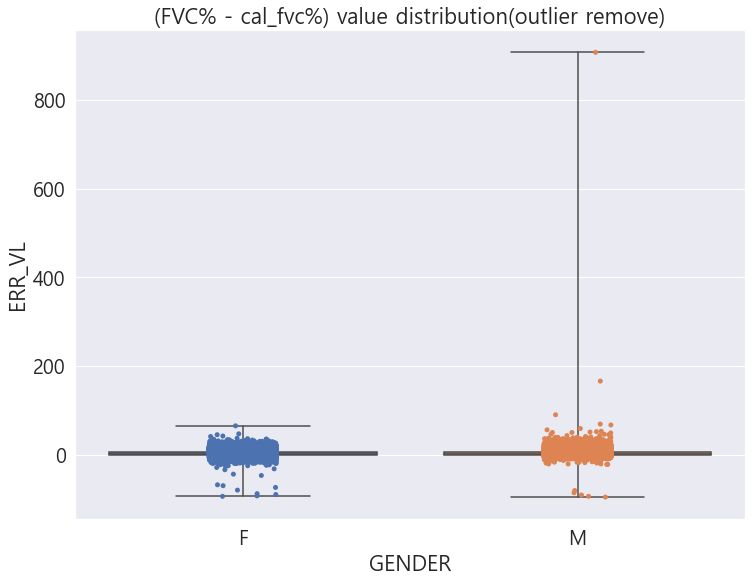

In [12]:
sns.set(font_scale = 1.8,font='Malgun Gothic')
plt.title("(FVC% - cal_fvc%) value distribution(outlier remove)")
# sns.violinplot(x="GENDER", y="ERR_VL",data=data2)
sns.boxplot(x="GENDER", y="ERR_VL",data=data2, whis=np.inf)
sns.stripplot(x="GENDER", y="ERR_VL",data=data2, jitter=True)#, color="0.4")

plt.show()